# What is Modem?

I bet that you've heard the word modem before.  Isn't it that box that gives me internet access? But do you know what it is?  A modem is shorthand for *modulator-demodulation*.

Modulation is all about transmitting information through a medium, or *channel*, in some specific way.  Information is
conveyed by modifying a template signal in a prescribed way that is understood by a receiver.  Here's our template signal:

\begin{equation}
    x(t) = A (t) \cos \left(\omega (t) t + \phi (t) \right). 
\end{equation}

Information is injected into this template by varying the amplitude $A(t)$, angular frequency $\omega (t)$, and or phase $\phi(t)$.  In this post, we will introduce a family of modulation techniques centered on varying the phase, called *Phase Shift Keying* (PSK).


## PSK Modulation

The standard derivation of PSK modulation follows from standard trigonometric identities:  

\begin{align}
    x_{p}(t) &= \cos (2\pi f_{c} t + \phi(t)) \\
             &= \cos (\phi(t)) \cos (2\pi f_{c} t) - \sin (\phi(t)) \sin (2\pi f_{c} t) \\
             &= I(t) \cos (2\pi f_{c} t) - Q(t) \sin (2\pi f_{c} t) 
\end{align}

The $I(t)= \cos (\phi(t))$ and $Q(t)=\sin (\phi(t))$ are the inphase and quadrature waveforms.  If you take a step back, you can see an interesting phenomena: phase modulation is equivalent to amplitude modulation.

It turns out to be very convenient to represent this last expression in terms of complex waveforms:

\begin{align}
    x_{c} (t) = \operatorname{Re} (z_{b} (t) \exp(2\pi i f_{c} t)) 
\end{align}

where $z_{b} (t)$ is the complex baseband waveform

\begin{equation}
    z_{b} (t) = I(t) + i Q(t)=\exp(i\phi(t)).
\end{equation}

The complex formulation is great because it seperates the baseband waveform, $z_{b}$, from the potentially much higher frequency carrier.  

## PSK Demodulation


### Bits and Symbols

The most fundamental unit of information is digital communication is the bit.  Different modulation schemes package up groups of bits into larger pieces of data called symbols.  Below are constellation diagrams for two very common and effective PSK schemes: BPSK and QPSK.  Constellation diagrams provide a compact way of describing the correspondance between bits, symbols, phases, and amplitude levels.    

![title](images/constellation.png)

The QPSK constellation is a little more interesting so I'll work on describing it in a little more detail.  Let's provide some context.  Suppose you want to transmit the bit sequence 

\begin{equation}
    b = \left[ 0,1,1,0,1,0,0,1,0,1,0,0,1,1,1,0,1,0\right]
\end{equation}

through some unspecified channel.  In QPSK, each symbol is made from two consecutive bits.  Our bit sequence is therefore transformed into the following sequence of symbols:

\begin{equation}
    s = \left[ 01, 10, 10, 01, 01, 00, 11, 10, 10 \right].
\end{equation}

So far so good.  Now we need to consult the constellation diagram.  If we want to transmit the symbol $01$, then we should choose 

\begin{equation}
    \phi(t) = \frac{3\pi}{4}, \quad 0\le t \le T
\end{equation}

which means that the baseband waveform for this time segment should be

\begin{equation}
    z_{b} (t) = I(t) + i Q(t) 
              = \cos(\phi(t)) + \sin(\phi(t)) 
              = -\frac{\sqrt{2}}{2} + i\frac{\sqrt{2}}{2}.
\end{equation}

The time variable $T$ represents the duration of each symbol.  Its reciprocal is commonly called the symbol rate, 
or baud rate.  Another parameter we need to start thinking about is the number of samples per symbol.  You get this by dividing the sample rate by the symbol rate.


## Distributed Systems

We're eventually going to start implementing some of these ideas in Python.  But first we need to think about the overall system design.  I naturally default to object oriented principles, that's probably not the right approach here.  I think it's more appropriate to view the system in terms of dataflow.  Before we get to an implementation of these ideas, let's explore tools from the Python language we can use to realize a true dataflow.


![title](images/stream_qpsk.png)

### Coroutines

I'm not going to formally define coroutines here.  There are plenty of resources out there for that.  What I will say is that they are a very convenient tool for building stream-processing systems.  Stream processing is probably another thing that requires a formal definition, but I'm not going to go there.  I'm going to call something a stream processor, or transducer, when it converts one stream into another.  And a stream is just what it sounds like; a possibly infinite sequence of data.  Since we can't store an infinite sequence of anything in memory, a stream processor will operate on a per-element basis.

For technical reasons, it's really handy to define a decorator for dealing with coroutines in Python.  Otherwise, we would need to *prime* it manually.  Here's a decorator that does the initialization magic.  The `func` function passed to `coroutine` is the actual coroutine.  

In [5]:
import numpy as np

In [7]:
def coroutine(func):
    def wrapper(*args,**kwargs):
        f = func(*args,**kwargs)
        f.send(None)
        return f
    return wrapper

Here's an example of a very simple stream processor you would find in any book on digital electronics, a D flip-flop.  I think it's fair to say that flip-flops are amongst the most fundamental and important components in FPGA design.  And they can get quite a bit more compplicated than this one.  A D flip flop can be used to store a bit for safe keeping, or until directed otherwise.  You can also add some delay to a bitstream by chaining a bunch of D flip flops together.

In [8]:
@coroutine
def flip_flop(outport):
    reg = 0
    while True:
        new = (yield)
        outport.send(reg)
        reg = new

This is a pretty straight forward function.  The `reg` is a 1 bit register that stores incoming data.  After this, the function runs forever, but pauses its execution at the `(yield)` statement until it receives data from another process.  This received data is bound to the `new` variable and the value stored in `reg` is sent to the coroutine indicated by `outport`.  Finally the freshly received data is bound to `reg`.  

Whew!  That was a mouthful.  Let's test it out.  First, we need another coroutine that gets the output from the flip flop and prints it to the screen.

In [9]:
@coroutine
def view():
    while True:
        x = (yield)
        print(x)

Now we need to create each of these two coroutines and pump some bits through.  Notice that the output is indeed delayed by a single bit.

In [10]:
v = view()
d = flip_flop(v)

for b in [1,0,1,0,1,0,0,1]:
    d.send(b)

0
1
0
1
0
1
0
0


That's progress.  Just for fun let's try to add a 3 element delay.  Notice how we define the chain in the reverse order; from the end to the start.

In [11]:
v = view()
d1 = flip_flop(v)
d2 = flip_flop(d1)
d3 = flip_flop(d2)

for b in [1,0,1,0,1,0,0,1]:
    d3.send(b)

0
0
0
1
0
1
0
1


That's enough flip-flop stuff for now.  Let's start building some coroutines for building our QPSK modulator.  First, here's a coroutine for transforming a stream of points on the QPSK constellation.  Notice that we have two `yield` statements here, one for each bit we want to capture.

In [63]:
@coroutine
def qpsk_symbols(outport):
    while True:
        b1 = (yield)
        b2 = (yield)
        z = None
        symbol = b2 + (b1 << 1)
        if symbol == 0:
            z = np.exp(5*1j*np.pi/4)
        elif symbol == 1:
            z = np.exp(3*1j*np.pi/4)
        elif symbol == 2:
            z = np.exp(7*1j*np.pi/4)
        elif symbol == 3:
            z = np.exp(np.pi*1j/4)
            
        if type(outport) is not list:
            outport.send(z)
        else:
            for oi in outport:
                oi.send(z)       

Next, we need a coroutine that converts the complex symbol stream into a stream of complex-valued samples.  We do this by introducing a waveform generator called a matched filter.  The reason for the *matched* in its name comes from the fact that the receiver will need to have it for demodulation.

As you can see in the `qpsk_matched_filter` coroutine below, each incoming symbol is being converted into a multi-sample waveform.  This is an example of a multirate signal processing block.  And it's actually not the first one we've seen.  The `qpsk_symbols` coroutine converts bit rate to symbol rate.

For those of you familiar with functional programming principles this matched filter coroutine looks like the type of function
you would pass to `flatmap` (or `bind` or `mapcat`). 

In [64]:
@coroutine
def qpsk_matched_filter(samples_per_symbol,outport):
    while True:
        x = (yield)
        y = [x]*samples_per_symbol
        for yi in y:
            
            if type(outport) is not list:
                outport.send(yi)
            else:
                for oi in outport:
                    oi.send(yi)                

@coroutine
def aggregate(coll):
    while True:
        x = (yield)
        coll.append(x)

Let's check our progress so far.  I'll do this by chaining some of the stream processors together and plotting the $I$ and $Q$ streams.  Here's what I want to do grapically:

In [62]:
type([1,4]) is list

True

And here's the chain translated to code:

In [65]:
result = []
a  = aggregate(result)
q1 = qpsk_matched_filter(16,a)
q2 = qpsk_symbols(q1) 

bits = np.random.randint(0,2,100)
for b in bits:
    q2.send(b)
 

The `result` array should now be full of complex-valued samples, let's check.

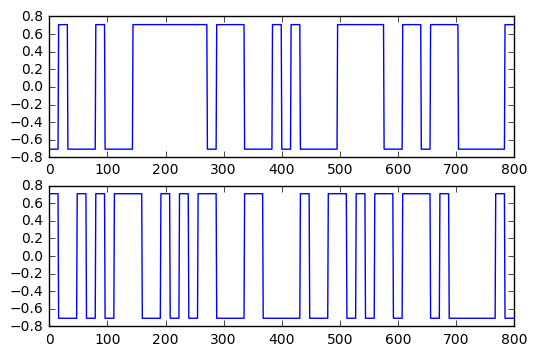

In [66]:
import matplotlib.pyplot as plt

x = [i for i in range(len(result))]
plt.subplot(211)
plt.plot(x,np.real(result))

plt.subplot(212)
plt.plot(x,np.imag(result))
plt.show()

For reasons we will discuss in more detail later, using these $I$ and $Q$ waveforms to transmit information is generally a bad idea.  The abrupt changes between positive and negative samples causes energy to spray into frequency bands that we have no need to encroach on.  It turns out there's an easy fix to this problem, and we will get into it more deeply in a later post.

Next, let's try to take this *baseband* signal and translate it up to a higher frequency.  As before, we need to implement a coroutine that specifies the action, sample by sample.  That's not too challenging.  To define an upconverter, you need to know the sample rate and the center frequency.  Here's one possible implementation:

In [89]:
@coroutine
def upconvert(sample_rate,center_frequency,outport):
    ratio = center_frequency / sample_rate
    state = 0.0
    two_pi = 2.0*np.pi
    while True:
        z0 = (yield)
        z1 = z0 * np.exp(two_pi*1j*state)
        
        if type(outport) is not list:
            outport.send(z1)
        else:
            for oi in outport:
                oi.send(z1)             

        state += ratio
        

To test this piece out, let's tack it onto the sequence of coroutines we used before:

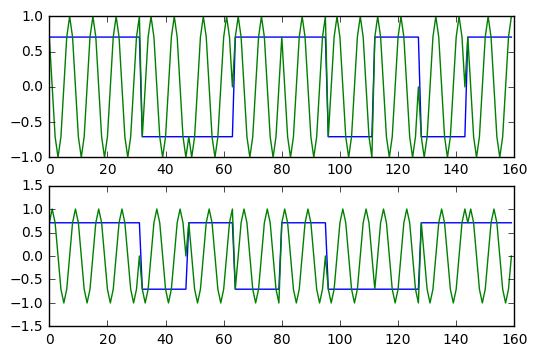

In [93]:
baseband = []
passband = []
baseband_a = aggregate(baseband)
passband_a = aggregate(passband)

q0 = upconvert(16000,2000,passband_a)
q1 = qpsk_matched_filter(16,[q0,baseband_a])
q2 = qpsk_symbols(q1) 

bits = np.random.randint(0,2,20)
for b in bits:
    q2.send(b)

import matplotlib.pyplot as plt

x = [i for i in range(8*len(bits))]

plt.subplot(211)
plt.plot(x,np.real(baseband))
plt.plot(x,np.real(passband))


plt.subplot(212)
plt.plot(x,np.imag(baseband))
plt.plot(x,np.imag(passband))
plt.show()    

In [30]:
1/3

0.3333333333333333